###  GPU vs CPU (single core) benchmark on MNIST

System: i7 8550U (4 cores), 16 GB ram, Geforce MX150 (2GB), windows 10

using Cuda toolkit 8.0.16, CuDNN 8.0, python 3.5, tensorflow XXX, visual studio 2015

In [2]:
import tensorflow as tf
import numpy as np                                
import matplotlib.pyplot as plt
import keras as k
from tensorflow.examples.tutorials.mnist import input_data
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.models import load_model
from keras import backend as K

Using TensorFlow backend.


In [62]:
#data preprocessing
(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_rows, img_cols = 28,28
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
x_test=x_test.astype('float32')
x_train=x_train.astype('float32')
mean=np.mean(x_train)
std=np.std(x_train)
x_test = (x_test-mean)/std
x_train = (x_train-mean)/std

In [63]:
#labels
num_classes=10
y_train = k.utils.to_categorical(y_train, num_classes)
y_test = k.utils.to_categorical(y_test, num_classes)

In [64]:
#build model

num_filter=32
num_dense=512
drop_dense=0.7
ac='relu'
learningrate=0.001

model = Sequential()

model.add(Conv2D(num_filter, (3, 3), activation=ac, input_shape=(28, 28, 1),padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(num_filter, (3, 3), activation=ac,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 14x14x32

model.add(Conv2D(2*num_filter, (3, 3), activation=ac,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(2*num_filter, (3, 3), activation=ac,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 7x7x64 = 3136 neurons

model.add(Flatten())                        
model.add(Dense(num_dense, activation=ac))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(10, activation='softmax'))

adm=Adam(lr=learningrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=adm)

Now we train the model with gpu or cpu for different batch sizes. The larger the batch size, the more the parallelisation of matrix multiplications in the gpu speeds up the training compared to the cpu. The gpu load goes up to 95 percent for batch size 512, with 1.6GB used. Much larger batches require better graphics cards.

In [37]:
# with GPU (the default in my setup)
for i in range(7):
    k=8*2**i
    print("batch size "+str(k))
    model.fit(x_train, y_train, batch_size=k, epochs=1, validation_data=(x_test, y_test))

batch size 8
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 267s 4ms/step - loss: 0.2297 - acc: 0.9314 - val_loss: 0.0552 - val_acc: 0.9838
batch size 16
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 150s 3ms/step - loss: 0.0806 - acc: 0.9770 - val_loss: 0.0724 - val_acc: 0.9792
batch size 32
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 96s 2ms/step - loss: 0.0418 - acc: 0.9876 - val_loss: 0.0242 - val_acc: 0.9928
batch size 64
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 71s 1ms/step - loss: 0.0256 - acc: 0.9920 - val_loss: 0.0156 - val_acc: 0.9947
batch size 128
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 57s 955us/step - loss: 0.0156 - acc: 0.9953 - val_loss: 0.0137 - val_acc: 0.9

In [65]:
# with CPU only: (tensorflow tries to use all cores available)

with tf.device("/cpu:0"):
    model = Sequential()

    model.add(Conv2D(num_filter, (3, 3), activation=ac, input_shape=(28, 28, 1),padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(num_filter, (3, 3), activation=ac,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 14x14x32

    model.add(Conv2D(2*num_filter, (3, 3), activation=ac,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(2*num_filter, (3, 3), activation=ac,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 7x7x64 = 3136 neurons

    model.add(Flatten())                        
    model.add(Dense(num_dense, activation=ac))
    model.add(BatchNormalization())
    model.add(Dropout(drop_dense))
    model.add(Dense(10, activation='softmax'))

    adm=Adam(lr=learningrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=adm)


In [66]:
with tf.device("/cpu:0"):
    for i in range(7):
        k=8*2**i
        print("batch size "+str(k))
        model.fit(x_train, y_train, batch_size=k, epochs=1, validation_data=(x_test, y_test))

batch size 8
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 574s 10ms/step - loss: 0.2261 - acc: 0.9336 - val_loss: 0.0635 - val_acc: 0.9830
batch size 16
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 478s 8ms/step - loss: 0.0752 - acc: 0.9776 - val_loss: 0.0432 - val_acc: 0.9869
batch size 32
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 437s 7ms/step - loss: 0.0394 - acc: 0.9880 - val_loss: 0.0278 - val_acc: 0.9912
batch size 64
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 404s 7ms/step - loss: 0.0233 - acc: 0.9932 - val_loss: 0.0149 - val_acc: 0.9952
batch size 128
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 350s 6ms/step - loss: 0.0147 - acc: 0.9954 - val_loss: 0.0157 - val_acc: 0

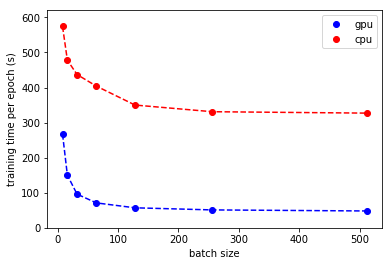

In [17]:
# plot the comparison. The training with gpu is faster by a factor of about 4-6
batch_sizes=[8,16,32,64,128,256,512]
gpu_list=[267,150,96,71,57,51,48]
cpu_list=[574,478,437,404,350,331,327]
plt.plot(batch_sizes,gpu_list,'bo')
plt.plot(batch_sizes,cpu_list,'ro')
plt.plot(batch_sizes,gpu_list,'b--')
plt.plot(batch_sizes,cpu_list,'r--')
plt.ylabel('training time per epoch (s)')
plt.xlabel('batch size')
plt.legend(['gpu', 'cpu'], loc='upper right')
plt.ylim([0,620])
#plt.savefig('CPUvsGPU.png') 
plt.show()

In [24]:
ratio_list=[j/k for (j, k) in zip(cpu_list,gpu_list)]
ratio_list

[2.149812734082397,
 3.1866666666666665,
 4.552083333333333,
 5.690140845070423,
 6.140350877192983,
 6.490196078431373,
 6.8125]